In [197]:
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal
import numpy as np
import pdb
import copy
import copy
import torch

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), keepdims=True)

device = 'cpu'

In [198]:
def soft_update(target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

In [199]:
class ReplayBuffer():
    def __init__(self,input_shape, n_actions,max_size=int(1e6)):
        self.memory_size = max_size
        self.memory_counter = 0
        self.state = np.zeros((self.memory_size, input_shape))
        self.state_ = np.zeros((self.memory_size, input_shape))
        self.action = np.zeros((self.memory_size, n_actions))
        self.reward = np.zeros(self.memory_size)
        self.done = np.zeros(self.memory_size)

    def add(self, state, action, reward, state_, done):
        index = self.memory_counter % self.memory_size
        self.state[index] = state
        self.state_[index] = state_
        self.action[index] = action
        self.reward[index] = reward
        self.done[index] = done
        self.memory_counter += 1

    def sample(self, batch_size):
        max_memory = min(self.memory_counter, self.memory_size)
        batch = np.random.choice(max_memory, batch_size)
        state = self.state[batch]
        action= self.action[batch]
        reward = self.reward[batch]
        state_ = self.state_[batch]
        done = self.done[batch]
        return state, action, reward, state_, done

In [200]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.l1 = nn.Linear(state_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, action_dim)
        self.max_action = max_action
    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        a = F.relu(self.l3(a))
        return self.max_action * torch.sigmoid(self.l4(a))

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        # Q1 architecture
        self.l1 = nn.Linear(state_dim + action_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 128)
        self.l4 = nn.Linear(128, 1)
        # Q2 architecture
        self.l5 = nn.Linear(state_dim + action_dim, 256)
        self.l6 = nn.Linear(256, 256)
        self.l7 = nn.Linear(256, 128)
        self.l8 = nn.Linear(128, 1)
    def forward(self, state, action):
        sa = torch.cat([state, action], 1)
        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = F.relu(self.l3(q1))
        q1 = self.l4(q1)

        q2 = F.relu(self.l5(sa))
        q2 = F.relu(self.l6(q2))
        q2 = F.relu(self.l7(q2))
        q2 = self.l8(q2)

        return q1, q2
    
    def Q1(self, state, action):
        sa = torch.cat([state, action], 1)
        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = F.relu(self.l3(q1))
        q1 = self.l4(q1)
        return q1

In [201]:
class TD3(object):
    def __init__(
        self,
        state_dim,
        action_dim,
        max_action,
        discount=0.99,
        tau=0.005,
        policy_noise=0.2,
        noise_clip=0.5,
        policy_freq=2
    ):

        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)
        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq
        self.total_it = 0

    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor(state).cpu().data.numpy().flatten()

    def train(self, replay_buffer, batch_size=100):
        if replay_buffer.memory_size<batch_size:
            return
        self.total_it += 1
        state, action, reward,next_state, not_done = replay_buffer.sample(batch_size)
        reward = T.tensor(reward, dtype=T.float)
        not_done = T.tensor(not_done,dtype=T.float)
        next_state = T.tensor(next_state, dtype=T.float)
        state = T.tensor(state, dtype=T.float)
        action = T.tensor(action, dtype=T.float)
        with torch.no_grad():
            noise = (
                torch.randn_like(action) * self.policy_noise
            ).clamp(-self.noise_clip, self.noise_clip)

            next_action = (
                self.actor_target(next_state) + noise
            ).clamp(-self.max_action, self.max_action)
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.squeeze(torch.min(target_Q1, target_Q2))
            target_Q = reward + not_done * self.discount * target_Q
        current_Q1, current_Q2 = self.critic(state, action)
        critic_loss = F.mse_loss(torch.squeeze(current_Q1), target_Q) + F.mse_loss(torch.squeeze(current_Q2), target_Q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        if self.total_it % self.policy_freq == 0:
            actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def save(self, filename):
        torch.save(self.critic.state_dict(), filename + "_critic")
        torch.save(self.critic_optimizer.state_dict(), filename + "_critic_optimizer")
        torch.save(self.actor.state_dict(), filename + "_actor")
        torch.save(self.actor_optimizer.state_dict(), filename + "_actor_optimizer")

    def load(self,filename='RL_alloc'):
        self.critic.load_state_dict(torch.load(filename + "_critic"))
        self.critic_optimizer.load_state_dict(torch.load(filename + "_critic_optimizer"))
        self.critic_target.load_state_dict(torch.load(filename + "_critic"))
        self.actor.load_state_dict(torch.load(filename + "_actor"))
        self.actor_optimizer.load_state_dict(torch.load(filename + "_actor_optimizer"))
        self.actor_target.load_state_dict(torch.load(filename + "_actor"))

In [202]:
action_dims=644 #number of subtasks

In [203]:
class Resource_Manager:
    def __init__(self,action_dims,resource_amount=100,max_steps=5000):
        self.resource_amount=np.expand_dims(np.array(resource_amount),axis=0)
        self.action_dims = (1,action_dims)
        self.space_dims=(1,self.action_dims[1]+1)
        self.max_steps=max_steps
        
    def reset(self):
        self.steps_so_far=0
        self.resource_requirements=softmax(np.random.randint(0,20,size=[self.action_dims[1]])) * 20000
        return self.get_state()
    
    def get_state(self):
        self.resource_amount=np.expand_dims(np.random.randint(20,220),axis=0)
        return np.concatenate([self.resource_amount,self.resource_requirements])
    
    def step(self, action):
        action=softmax(action) * self.resource_amount
        self.resource_requirements-= action    
        self.resource_requirements=np.clip(self.resource_requirements,0,max(max(self.resource_requirements),0))
        
        self.steps_so_far+=1
        if np.count_nonzero(self.resource_requirements)<1:
            return self.get_state(),1000,True,False
        return self.get_state(),-1,False,self.steps_so_far>=self.max_steps

In [204]:

def get_trained_policy():
    env =Resource_Manager(action_dims=action_dims)

    state_dim = env.space_dims[1]
    action_dim = env.action_dims[1]
    max_action = float(1)

    kwargs = {"state_dim": state_dim,"action_dim": action_dim,"max_action": max_action,"discount": 0.99,"tau": 0.005,}
    kwargs["policy_noise"] = 0.2 * max_action
    kwargs["noise_clip"] = 0.5 * max_action
    kwargs["policy_freq"] = 2
    policy = TD3(**kwargs)
    
    replay_buffer = ReplayBuffer(state_dim, action_dim)

    time_step=0
    start_timesteps=10000
    rewards=[]

    for episode in range(5000):
        episode_reward=0
        state = env.reset()
        done = False
        truncuated = False
        while (not done) and (not truncuated):
            action = (policy.select_action(state)+ np.random.normal(0, max_action * 0.1, size=action_dim)).clip(0, max_action)
            next_state, reward, done,truncuated = env.step(action)
            replay_buffer.add(state, action, reward,next_state, int(not(done)))
            if time_step > start_timesteps:
                policy.train(replay_buffer)
            state = next_state
            time_step+=1
            episode_reward+=reward
        rewards.append(episode_reward)
        if (episode%50)==0:
            print(f"episode:{episode} reward:{episode_reward} last_200_ep_AVG:{sum(rewards[-200:])/200}")
    print(state)
    return copy.deepcopy(policy.actor),copy.deepcopy(TD3(**kwargs).actor)

In [205]:
# allocator,random_allocator=get_trained_policy()
# allocator,random_allocator

In [206]:
class Resouce_Allocator:
    def __init__(self,allocator,task_list,task_dependencies=None,resource_requirements=None):
        self.task_dependencies=task_dependencies
        self.task_list=task_list
        self.allocator=allocator
        self.resources=resource_requirements
        self.steps=0
        self.done=np.array([False for j in range(len(resource_requirements))])
        self.terminal_state=False
        self.sub_tasks_done={}
        self.tasks_done={}
        self.utilization={}
        
    def alloc(self,available_amount,resourcces):
        state = torch.FloatTensor(np.c_[available_amount,resourcces]).to(device)
        return self.allocator(state).cpu().data.numpy().T
    
    def solve(self,avilable_resources,print_process=False):
        while self.check_to_do_list(print_process):
            self.steps+=1
            available_resource=np.array(avilable_resources)
            resource=copy.deepcopy(self.resources) 
            for index,done in zip(range(len(self.resources)),self.done):
                if index in self.task_dependencies.keys():
                        for dep in self.task_dependencies[index]:
                            if not self.done[dep]:
                                resource[index] = 0.0
            change=self.alloc(available_resource,resource.T)
            change[resource==0.0] = 0
            change=np.apply_along_axis(softmax, 0, change) * np.squeeze(available_resource)
            change[resource==0.0] = 0
            self.utilization[self.steps]=np.sum(change,axis=0)
            self.resources-= change
            self.resources=self.resources.clip(min=0)
            if print_process and (self.steps%500000000)==0:
                print(f"\n\n\nstep:{self.steps}\n available resources{available_resource}\nallocated resouces:{change}\n current needs:{self.resources}\n\n\n")            
        return self.steps,self.sub_tasks_done,self.tasks_done,self.utilization
    
    def check_to_do_list(self,print_process):
        for sub_task,index in zip(self.resources,range(len(self.resources))):
            
            count_done=len(self.sub_tasks_done)
            
            if sum(sub_task)<=0:
                if index not in self.sub_tasks_done.keys():
                    self.sub_tasks_done[index]=self.steps
                self.done[index]=True
            
            for key in self.task_list.keys():
                if self.done[self.task_list[key]].all():
                    if key not in self.tasks_done.keys():
                        self.tasks_done[key]=self.steps
                        
            if len(self.sub_tasks_done)>count_done and print_process:
                print(f"sub_task done: {self.sub_tasks_done.items()}")
                print(f"status of all tasks:{self.tasks_done}")
                        
        return not self.done.all()

In [207]:
import pandas as pd
df = pd.read_csv('task_subtask.csv')
task_list={}
for index, row in df.iterrows():
    if int(row['task_id']) in task_list.keys():   
        task_list[int(row['task_id'])].append(int(row['sub_task_id'])-1)
    else:
        task_list[int(row['task_id'])]=[int(row['sub_task_id'])-1]

df = pd.read_csv('sub_task_successor.csv')

order={}
for index, row in df.iterrows():
    if row['successor'] in order.keys():
        order[int(row['successor'])].append(int(row['sub_task_id']))
    else:
        order[int(row['successor'])] =[int(row['sub_task_id'])]


df = pd.read_csv('duration.csv')
duration={}
for index, row in df.iterrows():
        duration[int(row['sub_task_id'])-1] =int(row['duration'])


df = pd.read_csv('resources.csv')
resources={}
for index, row in df.iterrows():
        resources['R1']=int(row['R1'])
        resources['R2']=int(row['R2'])
        resources['R3']=int(row['R3'])
        resources['R4']=int(row['R4'])

df = pd.read_csv('requirements.csv')
requirements={}
for index, row in df.iterrows():
        requirements[int(row['sub_task_id'])-1]=[int(row['R1'])*duration[int(row['sub_task_id'])-1],int(row['R2'])*duration[int(row['sub_task_id'])-1],int(row['R3'])*duration[int(row['sub_task_id'])-1],int(row['R4'])*duration[int(row['sub_task_id'])-1]]
reqs=[]
for key in requirements.keys():
    reqs.append(requirements[key])
reqs=np.array(reqs, dtype=np.float64)
reqs.shape

(644, 4)

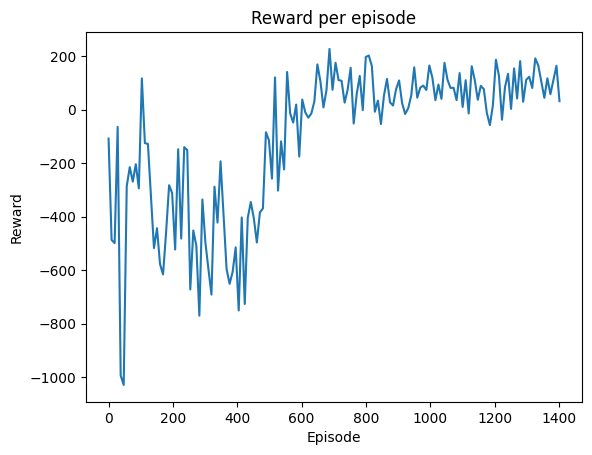

In [208]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt 
import pickle
rewards=[]
with open("temp_rewards", "rb") as fp:
    rewards = pickle.load(fp) 
# Dataset
x=np.array([i for i in range(len(rewards))])
y=np.array(rewards)
 
cubic_interpolation_model = interp1d(x, y, kind = "cubic")
 
# Plotting the Graph
X_=np.linspace(x.min(), x.max(), 150)
Y_=cubic_interpolation_model(X_)
 
plt.plot(X_, Y_)
plt.title("Reward per episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
# plt.savefig('avg.png', dpi=5000)#set to 5000 for maximum resolution
plt.show()

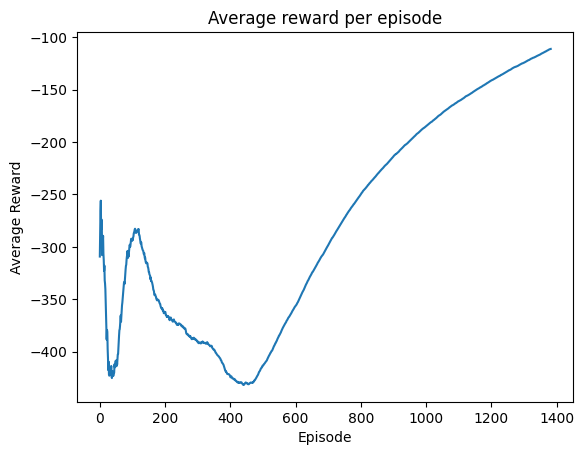

In [209]:
import matplotlib.pyplot as plt
rewards=[]
with open("temp_rewards", "rb") as fp:
    rewards = pickle.load(fp) 
avg_rewards=[]
for i in range(len(rewards)):
    avg_rewards.append(sum(rewards[:i])/(i+1)) #its sum of all not sum of last n ones


plt.plot(avg_rewards[20:])
plt.title("Average reward per episode")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
# plt.savefig('avg.png', dpi=5000)#set to 5000 for maximum resolution
plt.show()

In [210]:
env =Resource_Manager(action_dims=action_dims)
state_dim = env.space_dims[1]
action_dim = env.action_dims[1]
max_action = float(1)
kwargs = {"state_dim": state_dim,"action_dim": action_dim,"max_action": max_action,"discount": 0.99,"tau": 0.005,}
kwargs["policy_noise"] = 0.2 * max_action
kwargs["noise_clip"] = 0.5 * max_action
kwargs["policy_freq"] = 2

#testing random policy

In [211]:
#random policy
r1=Resouce_Allocator(allocator=copy.deepcopy(TD3(**kwargs).actor),task_list=task_list,task_dependencies=order,resource_requirements=copy.deepcopy(reqs))
stp,sub_task_done,task_done,utilization=r1.solve(avilable_resources= [[resources['R1']], [resources['R2']], [resources['R3']], [resources['R4']]])
print(stp)

10144


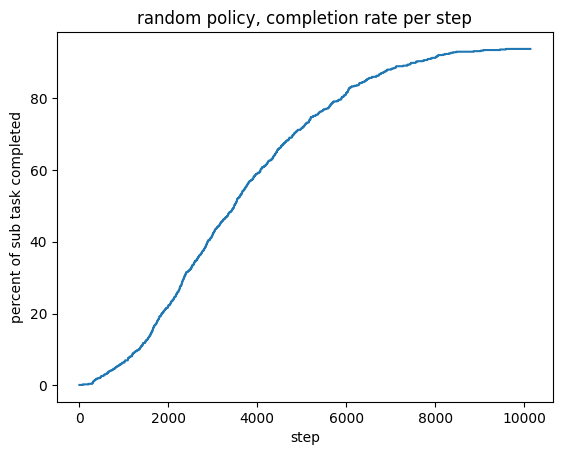

In [212]:
sub_tasks=(reqs.shape)[0]
completion_rate=[]
cntr=0
for i in range(stp):
    if i in sub_task_done.values():
        cntr+=1
    completion_rate.append((cntr/sub_tasks)*100)

plt.plot(completion_rate)
plt.title("random policy, completion rate per step")
plt.xlabel("step")
plt.ylabel("percent of sub task completed")
# plt.savefig('percent_of_sub_task_completed.png', dpi=5000)
plt.show()

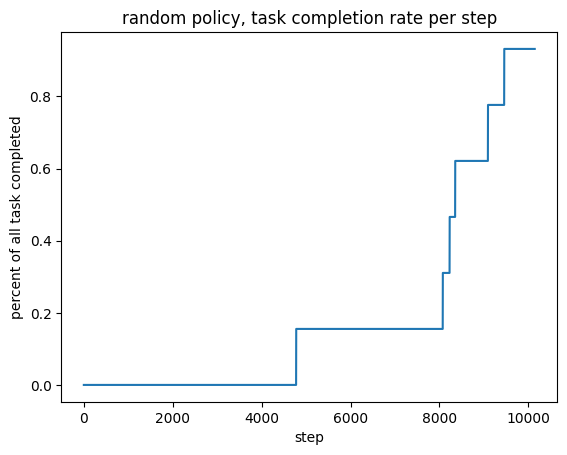

In [213]:
all_tasks=len(task_list.keys())
completion_rate=[]
cntr=0
for i in range(stp):
    if i in task_done.values():
        cntr+=1
    completion_rate.append((cntr/sub_tasks)*100)

plt.plot(completion_rate)
plt.title("random policy, task completion rate per step")
plt.xlabel("step")
plt.ylabel("percent of all task completed")
# plt.savefig('percent_of_all_tasks_completed.png', dpi=5000)
plt.show()

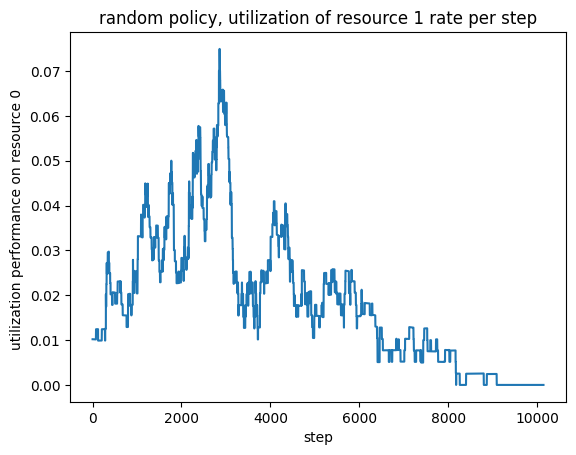

In [214]:
resource_index=0
steps=[]
utility=[]
for index in range(len(utilization)):
    # steps.add(index)
    utility.append(utilization[index+1][resource_index]/resources['R1'])
plt.plot(utility)
plt.title(f"random policy, utilization of resource {resource_index+1} rate per step")
plt.xlabel("step")
plt.ylabel(f"utilization performance on resource {resource_index} ")
# plt.savefig('percent_of_all_tasks_completed.png', dpi=5000)
plt.show()

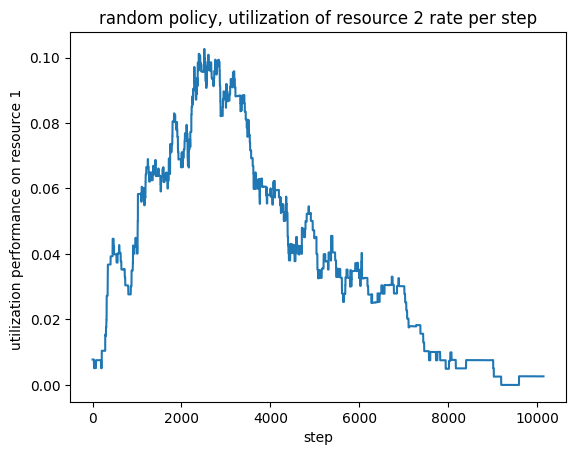

In [215]:
resource_index=1
steps=[]
utility=[]
for index in range(len(utilization)):
    # steps.add(index)
    utility.append(utilization[index+1][resource_index]/resources['R2'])
plt.plot(utility)
plt.title(f"random policy, utilization of resource {resource_index+1} rate per step")
plt.xlabel("step")
plt.ylabel(f"utilization performance on resource {resource_index} ")
# plt.savefig('percent_of_all_tasks_completed.png', dpi=5000)
plt.show()

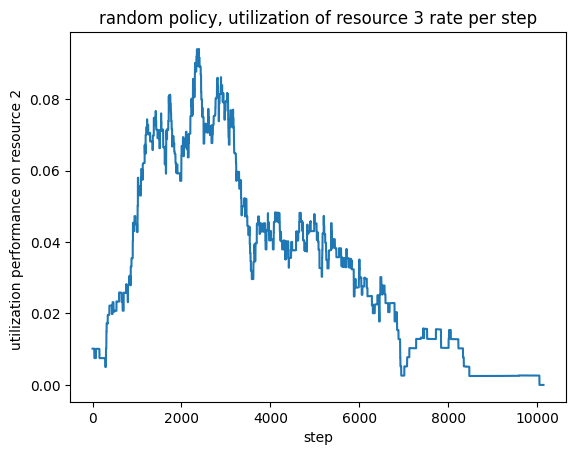

In [216]:
resource_index=2
steps=[]
utility=[]
for index in range(len(utilization)):
    # steps.add(index)
    utility.append(utilization[index+1][resource_index]/resources['R3'])
plt.plot(utility)
plt.title(f"random policy, utilization of resource {resource_index+1} rate per step")
plt.xlabel("step")
plt.ylabel(f"utilization performance on resource {resource_index} ")
# plt.savefig('percent_of_all_tasks_completed.png', dpi=5000)
plt.show()

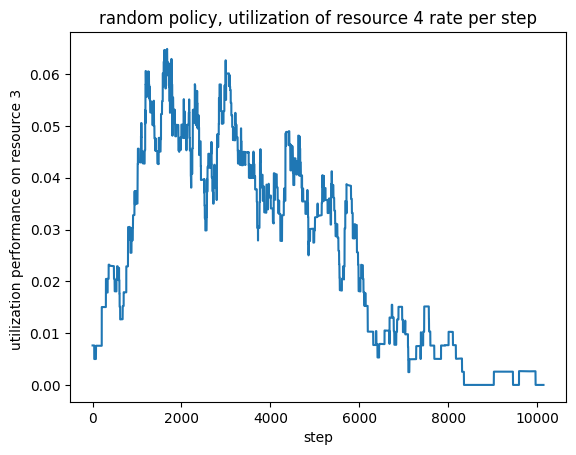

In [217]:
resource_index=3
steps=[]
utility=[]
for index in range(len(utilization)):
    # steps.add(index)
    utility.append(utilization[index+1][resource_index]/resources['R4'])
plt.plot(utility)
plt.title(f"random policy, utilization of resource {resource_index+1} rate per step")
plt.xlabel("step")
plt.ylabel(f"utilization performance on resource {resource_index} ")
# plt.savefig('percent_of_all_tasks_completed.png', dpi=5000)
plt.show()

#testing trained policy

In [218]:
# good trained policy
policy = TD3(**kwargs)
policy.load()

r1=Resouce_Allocator(allocator=policy.actor,task_list=task_list,task_dependencies=order,resource_requirements=copy.deepcopy(reqs))
stp,sub_task_done,task_done,utilization=r1.solve(avilable_resources= [[resources['R1']], [resources['R2']], [resources['R3']], [resources['R4']]])
print(stp)

C:\Users\AG\AppData\Local\Temp\ipykernel_24888\100479648.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.critic.load_state_dict(torch.load(filename + "_critic"))
C

6192


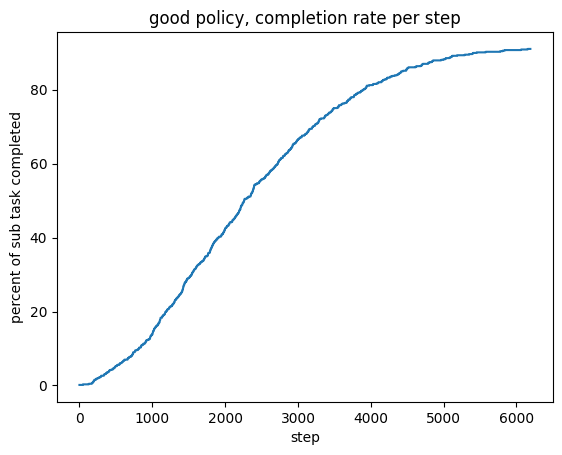

In [219]:
sub_tasks=(reqs.shape)[0]
completion_rate=[]
cntr=0
for i in range(stp):
    if i in sub_task_done.values():
        cntr+=1
    completion_rate.append((cntr/sub_tasks)*100)

plt.plot(completion_rate)
plt.title("good policy, completion rate per step")
plt.xlabel("step")
plt.ylabel("percent of sub task completed")
# plt.savefig('percent_of_sub_task_completed.png', dpi=5000)
plt.show()

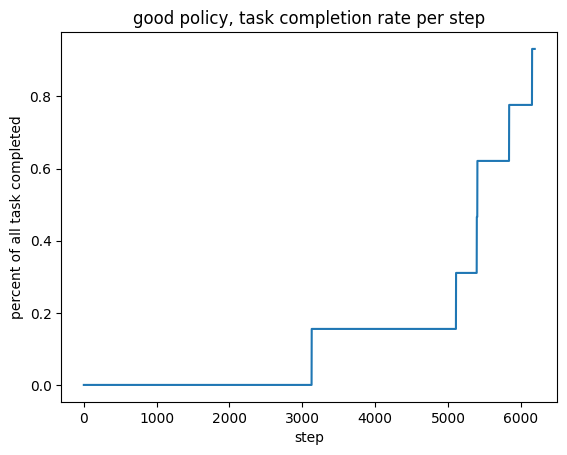

In [220]:
all_tasks=len(task_list.keys())
completion_rate=[]
cntr=0
for i in range(stp):
    if i in task_done.values():
        cntr+=1
    completion_rate.append((cntr/sub_tasks)*100)

plt.plot(completion_rate)
plt.title("good policy, task completion rate per step")
plt.xlabel("step")
plt.ylabel("percent of all task completed")
# plt.savefig('percent_of_all_tasks_completed.png', dpi=5000)
plt.show()

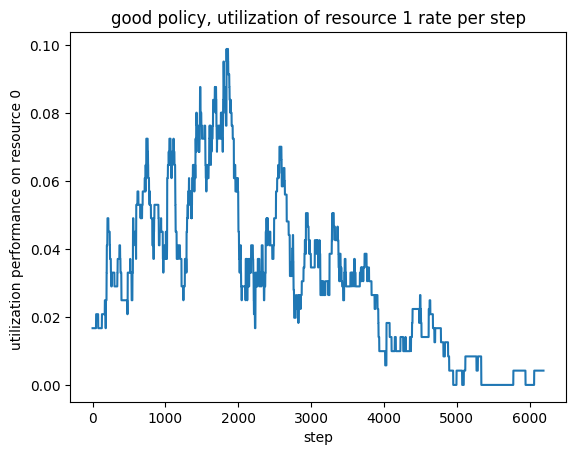

In [221]:
resource_index=0
steps=[]
utility=[]
for index in range(len(utilization)):
    # steps.add(index)
    utility.append(utilization[index+1][resource_index]/resources['R1'])
plt.plot(utility)
plt.title(f"good policy, utilization of resource {resource_index+1} rate per step")
plt.xlabel("step")
plt.ylabel(f"utilization performance on resource {resource_index} ")
# plt.savefig('percent_of_all_tasks_completed.png', dpi=5000)
plt.show()

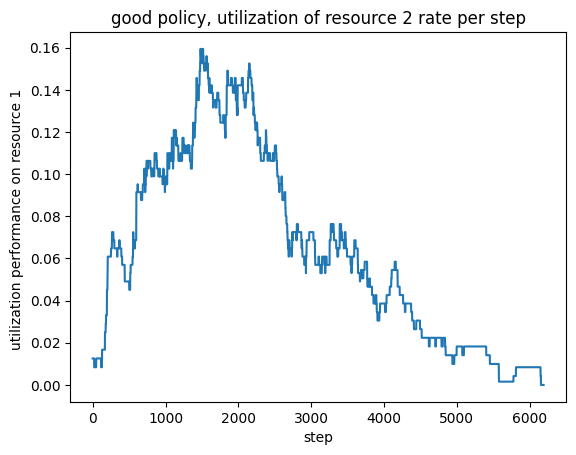

In [222]:
resource_index=1
steps=[]
utility=[]
for index in range(len(utilization)):
    # steps.add(index)
    utility.append(utilization[index+1][resource_index]/resources['R2'])
plt.plot(utility)
plt.title(f"good policy, utilization of resource {resource_index+1} rate per step")
plt.xlabel("step")
plt.ylabel(f"utilization performance on resource {resource_index} ")
# plt.savefig('percent_of_all_tasks_completed.png', dpi=5000)
plt.show()

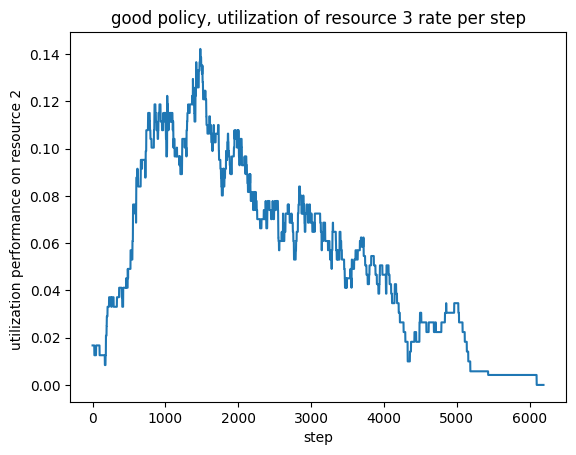

In [223]:
resource_index=2
steps=[]
utility=[]
for index in range(len(utilization)):
    # steps.add(index)
    utility.append(utilization[index+1][resource_index]/resources['R3'])
plt.plot(utility)
plt.title(f"good policy, utilization of resource {resource_index+1} rate per step")
plt.xlabel("step")
plt.ylabel(f"utilization performance on resource {resource_index} ")
# plt.savefig('percent_of_all_tasks_completed.png', dpi=5000)
plt.show()

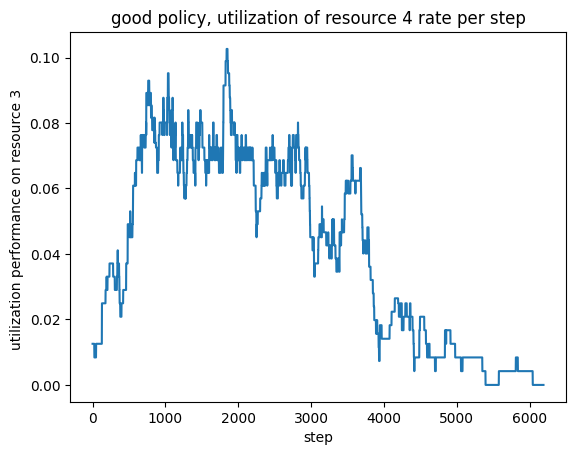

In [224]:
resource_index=3
steps=[]
utility=[]
for index in range(len(utilization)):
    # steps.add(index)
    utility.append(utilization[index+1][resource_index]/resources['R4'])
plt.plot(utility)
plt.title(f"good policy, utilization of resource {resource_index+1} rate per step")
plt.xlabel("step")
plt.ylabel(f"utilization performance on resource {resource_index} ")
# plt.savefig('percent_of_all_tasks_completed.png', dpi=5000)
plt.show()